# 1.0 - Entendimento de negócio


## 1.1 - Descrição do Problema
Hoje, o consumidor é moderno: está sempre informado, conectado e é exigente. Sabe que, se precisar de ajuda para um problema, pode recorrer a outros lugares, como o site do consumidor.gov. 

Lá, ele pode formalizar uma reclamação, que poderá ou não ser resolvida.

Se o problema não for resolvido, como ficará a imagem da empresa perante outros consumidores? 

De que vale o investimento em mídias se, ao acessar uma plataforma governamental oficial para reclamações, um potencial cliente encontrar várias que foram avaliadas como não resolvidas?


## 1.2 - Objetivo do Modelo

O objetivo deste modelo de aprendizado de máquina que construímos é fornecer à empresa uma ferramenta capaz de identificar se o consumidor irá avaliar negativamente e, em casos afirmativos, dar à empresa a possibilidade de reverter essa intenção.

# 2.0 -  Coleta de Dados

## 2.1 - Fonte dos Dados

Os dados utilizados foram retirados do site do Consumidor.Gov.

Inicialmente, baixamos 12 arquivos, abrangendo um período de 12 meses, de julho de 2023 a junho de 2024.

Analisamos esses dados e filtramos os registros para reter apenas as informações relacionadas ao segmento de fabricantes de produtos eletrônicos, que será o foco do nosso modelo.

Você pode acessar a análise [aqui](analise_consumidor_gov.ipynb).


## 2.2 - Descrição dos Dados

As colunas são do dataset são:


- **Região**:

  - Indica a região do Brasil onde o consumidor está localizado.
 
- **UF**:

  - Sigla do estado da federação.

- **Cidade**:

  - Nome da cidade onde o consumidor está localizado.

- **Sexo**:

  - Sexo do consumidor (Masculino, feminino e Outros).

- **Faixa Etária**:

  - Faixa etária do consumidor, categorizada em intervalos de idade (até 20 anos, entre 21 a 30 anos, entre 31 a 40 anos, entre 41 a 50 anos, entre 51 a 60 anos, entre 61 a 70 anos, mais de 70 anos).

- **Data Finalização**:

  - Data em que a reclamação foi finalizada.

- **Tempo Resposta**:

  - Tempo que a empresa levou para responder à reclamação, medido em dias.

- **Nome Fantasia**:

  - Nome comercial da empresa que recebeu a reclamação.

- **Segmento de Mercado**:

  - Setor ou indústria em que a empresa opera.
- **Como Comprou/Contratou**:

  - Indica como o consumidor adquiriu o produto ou serviço (e.g., Online, Loja Física).

- **Procurou Empresa**:

  - Indica se o consumidor tentou resolver o problema diretamente com a empresa antes de registrar a reclamação.

- **Respondida**:

  - Indica se a empresa respondeu à reclamação do consumidor.

- **Situação**:

  - Situação atual da reclamação, indicando se foi resolvida.

- **Avaliação Reclamação**:

  - Avaliação do consumidor sobre a resolução da reclamação, geralmente indicando satisfação ou insatisfação.

- **Nota do Consumidor**:

  - Nota dada pelo consumidor, geralmente em uma escala de 1 a 5, avaliando o atendimento e a resolução do problema.






A seguir, iremos importar as bibliotecas que serão usadas nesse notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer 
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures,SmartCorrelatedSelection

from sklearn.ensemble import RandomForestClassifier
from xgboost import  XGBClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings


import pickle
warnings.filterwarnings("ignore")


In [3]:
data_segment = pd.read_csv('../data/processed/dados_consumidor_gov_anual.csv')
data_segment.sample(5, random_state=42)

,regiao,uf,cidade,sexo,faixa_etaria,data_finalizacao,tempo_resposta,nome_fantasia,segmento_de_mercado,area,assunto,grupo_problema,problema,como_comprou_contratou,procurou_empresa,respondida,situacao,avaliacao_reclamacao,nota_do_consumidor
6011,SE,SP,São Paulo,M,entre 41 a 50 anos,2023-09-11,3.0,Samsung,"Fabricantes - Eletroeletrônicos, Produtos de ...",Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Falta de a...,Internet,S,S,Finalizada não avaliada,Não Avaliada,NaN
26324,SE,MG,São João Del Rei,M,entre 31 a 40 anos,2024-05-03,7.0,Samsung,"Fabricantes - Eletroeletrônicos, Produtos de ...",Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Dificuldad...,Loja física,S,S,Finalizada não avaliada,Não Avaliada,NaN
18149,SE,SP,Bonfim Paulista,M,entre 21 a 30 anos,2024-02-05,5.0,Samsung,"Fabricantes - Eletroeletrônicos, Produtos de ...",Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Dificuldad...,Internet,N,S,Finalizada não avaliada,Não Avaliada,NaN
2141,S,PR,Castro,M,entre 21 a 30 anos,2023-07-28,1.0,Samsung,"Fabricantes - Eletroeletrônicos, Produtos de ...",Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Dificuldad...,Internet,S,S,Finalizada não avaliada,Não Avaliada,NaN
12462,CO,DF,Brasília,M,entre 61 a 70 anos,2023-11-16,2.0,LG Electronics,"Fabricantes - Eletroeletrônicos, Produtos de ...",Produtos Eletrodomésticos e Eletrônicos,Televisão,Atendimento / SAC,Dificuldade de contato / demora no atendimento,Internet,S,S,Finalizada avaliada,Resolvida,4.0


In [4]:
data_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28806 entries, 0 to 28805
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   regiao                  28806 non-null  object 
 1   uf                      28806 non-null  object 
 2   cidade                  28806 non-null  object 
 3   sexo                    28806 non-null  object 
 4   faixa_etaria            28806 non-null  object 
 5   data_finalizacao        28806 non-null  object 
 6   tempo_resposta          28513 non-null  float64
 7   nome_fantasia           28806 non-null  object 
 8   segmento_de_mercado     28806 non-null  object 
 9   area                    28806 non-null  object 
 10  assunto                 28806 non-null  object 
 11  grupo_problema          28806 non-null  object 
 12  problema                28806 non-null  object 
 13  como_comprou_contratou  28806 non-null  object 
 14  procurou_empresa        28806 non-null

# 3.0 - Pré-processamento de Dados

## 3.1 - Limpeza de Dados

Como visto anteriormente, faltam alguns valores em nossos dados.
 
Olharemos com mais atenção para esse valores para decidir como tratá-los.


In [5]:
data_segment.isnull().sum()

regiao                        0
uf                            0
cidade                        0
sexo                          0
faixa_etaria                  0
data_finalizacao              0
tempo_resposta              293
nome_fantasia                 0
segmento_de_mercado           0
area                          0
assunto                       0
grupo_problema                0
problema                      0
como_comprou_contratou        0
procurou_empresa              0
respondida                    0
situacao                      0
avaliacao_reclamacao          0
nota_do_consumidor        14339
dtype: int64

As colunas ```tempo_resposta``` e ```nota_do_consumidor``` possuem valores ausentes. 

No entanto, decidimos excluir essas colunas. 

A ```tempo_resposta``` representa os dias que a empresa levou para responder a uma reclamação, enquanto a ```nota_do_consumidor``` refere-se à avaliação das reclamações.
Além disso, a ausência de valores nessas colunas fornece duas informações importantes: 

293 reclamações foram encerradas sem a resposta pública da empresa, e 14.339 reclamações não foram avaliadas, por isso não possuem nota.

Junto com a ```nota_do_consumidor```, excluiremos a coluna ```situacao``` que indicam que as reclamações foram avaliadas, o que pode gerar vazamento de informações sobre nossa variável alvo ao modelo.


Além dela, a coluna ```segmento_de_mercado``` será excluída por possuir apenas um valor.


In [6]:
data_segment = data_segment.drop(['tempo_resposta','nota_do_consumidor','situacao','segmento_de_mercado'], axis=1)



Agora, olharemos para o nosso target. 

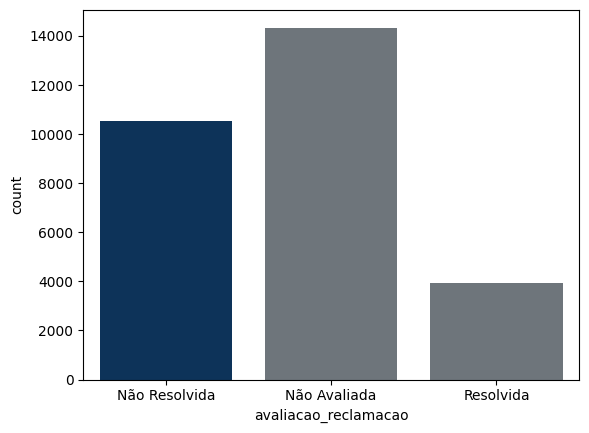

In [7]:
_=sns.countplot(data=data_segment, x='avaliacao_reclamacao', palette=['#003366','#6c757d','#6c757d'])

O nosso objetivo é prever se o consumidor possui tendência a avaliar negativamente uma reclamação e, a partir disso, seguir com algumas estratégias diferentes para minimizar essa situação.

A seguir, iremos tranformar o target em números, de 0 a 2. A seguir, iremos tranformar o target em números, de 0 a 2. 

In [8]:
target_mapping = {'Não Avaliada': 0,'Resolvida':1,'Não Resolvida':2}
data_segment['avaliacao_reclamacao'] = data_segment['avaliacao_reclamacao'].replace(target_mapping)

Abaixo, os valores únicos de cada coluna. 

In [9]:
data_segment.nunique()

regiao                       5
uf                          27
cidade                    2020
sexo                         3
faixa_etaria                 7
data_finalizacao           366
nome_fantasia               27
area                         7
assunto                     29
grupo_problema               8
problema                    55
como_comprou_contratou       9
procurou_empresa             2
respondida                   2
avaliacao_reclamacao         3
dtype: int64

A ```data_finalizacao``` possui o dia, mês e ano que a reclamação foi finalizada. 

Para deixála mais informativa, iremos transformá-la no mês em que a reclamação foi finalizada. 


In [10]:
data_segment['data_finalizacao'] = pd.to_datetime(data_segment['data_finalizacao'], format='%Y-%m-%d')
data_segment['data_finalizacao'] = data_segment['data_finalizacao'].dt.month

Além disso, os valores da coluna ```problema```que possuírem menos que 10 ocorrências serão transformados em “Outros”

In [11]:
limit = 10

problem_frequency = data_segment['problema'].value_counts()

common_values = problem_frequency[problem_frequency >= limit].index

data_segment['problema'] = data_segment['problema'].apply(lambda x: x if x in common_values else 'Outros')

In [12]:
data_segment.nunique()

regiao                       5
uf                          27
cidade                    2020
sexo                         3
faixa_etaria                 7
data_finalizacao            12
nome_fantasia               27
area                         7
assunto                     29
grupo_problema               8
problema                    40
como_comprou_contratou       9
procurou_empresa             2
respondida                   2
avaliacao_reclamacao         3
dtype: int64

Feitas as tranformaações, estes são os dados que usaremos em nosso modelo:

In [13]:
data_segment.sample(5, random_state=42)

,regiao,uf,cidade,sexo,faixa_etaria,data_finalizacao,nome_fantasia,area,assunto,grupo_problema,problema,como_comprou_contratou,procurou_empresa,respondida,avaliacao_reclamacao
6011,SE,SP,São Paulo,M,entre 41 a 50 anos,9,Samsung,Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Falta de a...,Internet,S,S,0
26324,SE,MG,São João Del Rei,M,entre 31 a 40 anos,5,Samsung,Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Dificuldad...,Loja física,S,S,0
18149,SE,SP,Bonfim Paulista,M,entre 21 a 30 anos,2,Samsung,Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Dificuldad...,Internet,N,S,0
2141,S,PR,Castro,M,entre 21 a 30 anos,7,Samsung,Produtos de Telefonia e Informática,Aparelho celular,Vício de Qualidade,Produto danificado / não funciona - Dificuldad...,Internet,S,S,0
12462,CO,DF,Brasília,M,entre 61 a 70 anos,11,LG Electronics,Produtos Eletrodomésticos e Eletrônicos,Televisão,Atendimento / SAC,Dificuldade de contato / demora no atendimento,Internet,S,S,1


## 3.2 - Divisão dos Dados

Vamos dividir nossos dados em preditores e a variável alvo.

In [14]:
X = data_segment.drop(['avaliacao_reclamacao'], axis=1)
y = data_segment['avaliacao_reclamacao']

Depois da divisão, iremos salvar a variável X em novo dataset. Isso será útil futuramente, quando precisarmos especificar as opções a serem selecionadas no streamlit. 

In [18]:
to_selection = X
#to_selection.to_csv('../data/processed/dados_consumidor_gov_to_streamlit.csv', index=False)



Como estamos trabalhando com um dataset de tamanho médio, optei por separar 30% dos dados para o teste. 

Além disso, o parâmetro  ```stratify=y``` garante que teremos uma proporção equilibrada dos valores da variável alvo em ambas as divisões.

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((20164, 14), (8642, 14), (20164,), (8642,))

## 3.3 - Transformações dos Dados

Como nossas classes estão desbalanceadas, vamos, primeiro, estabelecer os pesos para elas, o que facilitará o trabalho do modelo. 

In [23]:
class_weight = compute_class_weight("balanced", classes=np.unique(y_train),y=y_train)
weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weight)}

classes_weights_sample = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)


Feito isso, iremos definir as colunas que irão ser transformadas por meio do OneHotEncoder. 

As demais colunas, serão transformadas usando o TargetEncoder.


In [25]:
columns_one_hot = ['respondida', 'procurou_empresa', 'como_comprou_contratou', 'grupo_problema', 'area', 'faixa_etaria', 'sexo', 'regiao']
columns_to_encode_target = [col for col in X.columns if col not in columns_one_hot]
columns_to_scale = ['data_finalizacao'] 

In [26]:
preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(sparse_output=False, drop='first',handle_unknown='ignore'), columns_one_hot),
    ('target_encoder', TargetEncoder(), columns_to_encode_target),
    ('scaler', StandardScaler(), columns_to_scale)
    
])


# 4.0 -Modelagem

## 4.1 - Treinamento dos modelos


A seguir, definiremos os modelos e técnicas que serão utilizados. 


In [27]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight=weight_dict),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', objective='soft:prob'),
    'SGD Classifier': OneVsOneClassifier(SGDClassifier(random_state=42, class_weight=weight_dict)),
    'LightGBM': lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, class_weight=weight_dict),
    'Naive Bayes': OneVsRestClassifier(GaussianNB()),
    'SVM': SVC(probability=True, random_state=42, class_weight=weight_dict),
    'knn': OneVsRestClassifier(KNeighborsClassifier())
}

In [29]:
class_names = ['Não Avaliada 0', 'Resolvida 1', 'Não Resolvida 2']

for name, model in models.items():
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('drop', DropConstantFeatures(tol=0.998)),
        ('smart', SmartCorrelatedSelection(method='pearson', threshold=0.8)),
        ('clf', model)
    ])
    
   
    if name == 'XGBoost':
        fit_params = {'clf__sample_weight': classes_weights_sample}
    else:
        fit_params = {}
    
   
    pipeline.fit(X_train, y_train, **fit_params)

    y_pred = pipeline.predict(X_test)
    
  
    print(f'Métricas modelo: {name}\n')
    print(classification_report(y_test, y_pred, target_names=class_names))
    print('----------------------------\n')


Métricas modelo: Random Forest

                 precision    recall  f1-score   support

 Não Avaliada 0       0.55      0.68      0.61      4302
    Resolvida 1       0.26      0.09      0.14      1175
Não Resolvida 2       0.45      0.41      0.43      3165

       accuracy                           0.50      8642
      macro avg       0.42      0.39      0.39      8642
   weighted avg       0.47      0.50      0.48      8642

----------------------------

Métricas modelo: XGBoost

                 precision    recall  f1-score   support

 Não Avaliada 0       0.59      0.52      0.55      4302
    Resolvida 1       0.24      0.37      0.29      1175
Não Resolvida 2       0.45      0.43      0.44      3165

       accuracy                           0.47      8642
      macro avg       0.43      0.44      0.43      8642
   weighted avg       0.49      0.47      0.47      8642

----------------------------

Métricas modelo: SGD Classifier

                 precision    recall  f1-scor


Para o nosso problema, é importante que, quando o modelo disser que um consumidor irá avaliar uma reclamação de forma negativa, ele tenha uma alta taxa de acertos. 

Isso garante que conseguimos identificar corretamente as situações em que o cliente pode estar insatisfeito.

Com isso em mente, os modelos mais adequados ao nosso problema são **Naive Bayes**, **LightGBM** e **XGBoost**, porque tiveram os melhores resultados, se levarmos em consideração a precision e recall.


## 4.2 - Tunagem de hiperparâmetros


### 4.2.1 - Naive Bayes

In [30]:
pipe_naive = Pipeline([
    ('preprocessor', preprocessor),
    ('drop', DropConstantFeatures(tol=0.998)),
    ('smart', SmartCorrelatedSelection(method='pearson', threshold=0.8)),
    ('clf', GaussianNB())
])


param_grid_naive = {
    'clf__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 
                                      1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
    'clf__priors' : [None]
}


grid_search_naive = GridSearchCV(pipe_naive, param_grid_naive, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_naive.fit(X_train, y_train)


print("Melhores parâmetros Naive Bayes:", grid_search_naive.best_params_)
print("Melhor F1-Score:", grid_search_naive.best_score_)





/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242

Melhores parâmetros Naive Bayes: {'clf__priors': None, 'clf__var_smoothing': 0.01}
Melhor F1-Score: 0.46186693147253816


### 4.2.2 - XGBoost


In [57]:

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('drop', DropConstantFeatures(tol=0.998)),
    ('smart', SmartCorrelatedSelection(method='pearson', threshold=0.8)),
    ('clf', XGBClassifier(objective='multi:softmax', num_class=3))
])


param_grid_xgb = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__n_estimators': [50, 100, 200],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}


grid_search_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train, clf__sample_weight=classes_weights_sample)


print("Melhores parâmetros XGBoost:", grid_search_xgb.best_params_)
print("Melhor F1-Score:", grid_search_xgb.best_score_)


/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242

Melhores parâmetros XGBoost: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Melhor F1-Score: 0.4816594910688353


### 4.2.3 - LGBM

In [60]:


pipe_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('drop', DropConstantFeatures(tol=0.998)),
    ('smart', SmartCorrelatedSelection(method='pearson', threshold=0.8)), 
    ('clf', lgb.LGBMClassifier(objective='multiclass', num_class=3, class_weight=weight_dict))
])


param_grid_lgbm = {
    'clf__max_depth': [-1, 3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__n_estimators': [50, 100, 200],
    'clf__num_leaves': [31, 50, 100],
    'clf__min_child_samples': [20, 50, 100]
}


grid_search_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)


print("Melhores parâmetros LightGBM:", grid_search_lgbm.best_params_)
print("Melhor F1-Score:", grid_search_lgbm.best_score_)


/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/ronaldo/Desktop/Estudos/dados/projetos/gov-modelo/machine_consumidor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242

Melhores parâmetros LightGBM: {'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__min_child_samples': 20, 'clf__n_estimators': 200, 'clf__num_leaves': 100}
Melhor F1-Score: 0.4786357377257242


## 4.3 - Modelo escolhido

Como o Naive Bayes semhiperparâmetros, dos modelos treinados, foi o que apresentou o melhor F1-Score, ele será o escolhido para o primeiro protótipo.

Text(50.72222222222221, 0.5, 'Real')

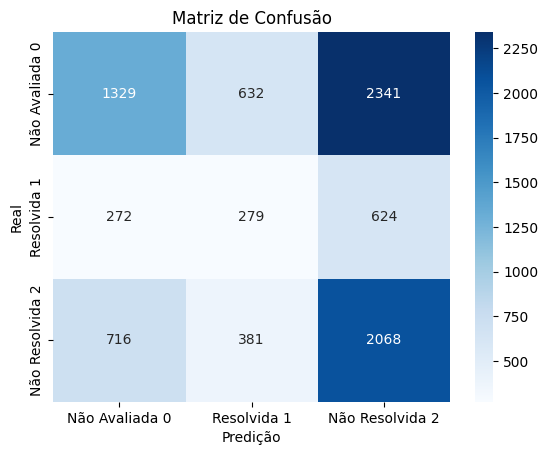

In [31]:
model_final = GaussianNB()

pipeline_naive = Pipeline([
    ('preprocessor', preprocessor),
    ('drop', DropConstantFeatures(tol=0.998)),
    ('smart', SmartCorrelatedSelection(method='pearson', threshold=0.8)),
    ('clf', model_final)
])

pipeline_naive.fit(X_train, y_train)

y_pred_pipeline_predict = pipeline_naive.predict(X_test)

cm = confusion_matrix(y_test,y_pred_pipeline_predict)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)


plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')

In [93]:


filename = '../model/modelo_naive_bayes.pkl'

with open(filename, 'wb') as file:
    pickle.dump(pipeline_naive, file)

print(f'Modelo salvo em {filename}')

Modelo salvo em ../model/modelo_naive_bayes.pkl
